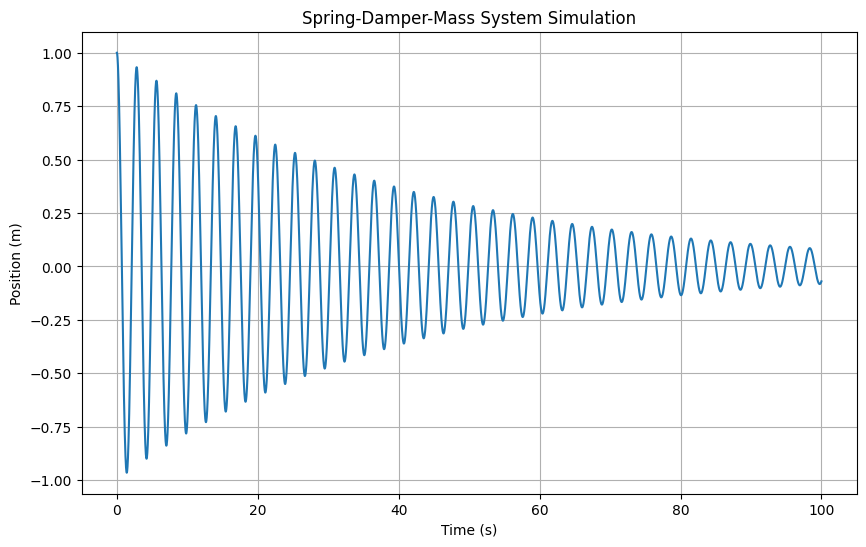

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# System parameters
m = 1.0  # mass (kg)
k = 5.0 # spring constant (N/m)
c = 0.05  # damping coefficient (Ns/m)

# Initial conditions
x0 = 1  # initial displacement (m)
v0 = 0.0  # initial velocity (m/s)

# Time parameters
t_start = 0.0
t_end = 100.0
dt = 0.01  # time step (s)
num_steps = int((t_end - t_start) / dt)

# Initialize arrays to store results
time = np.linspace(t_start, t_end, num_steps)
position = np.zeros(num_steps)
velocity = np.zeros(num_steps)

# Set initial conditions
position[0] = x0
velocity[0] = v0

# Simulation using Euler method
for i in range(num_steps - 1):
  # Calculate acceleration
  acceleration = (-k * position[i] - c * velocity[i]) / m

  # Update velocity and position
  velocity[i+1] = velocity[i] + acceleration * dt
  position[i+1] = position[i] + velocity[i+1] * dt # Using updated velocity

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time, position)
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Spring-Damper-Mass System Simulation')
plt.grid(True)
plt.show()


Sampled times: [20.2820282  21.12211221 24.05240524  9.9609961  12.46124612  5.94059406
  7.93079308  7.95079508 19.16191619 18.95189519  6.53065307 13.01130113
 19.9519952  19.8019802  15.19151915  1.96019602 21.17211721 23.08230823
  8.55085509 14.68146815 10.60106011 24.42244224 11.60116012 21.85218522
 21.06210621  6.62066207 12.71127113 11.78117812 12.34123412  9.20092009
 12.47124712  9.7509751  14.58145815 18.49184918 17.40174017 17.69176918
  6.73067307 13.82138214 19.6519652  14.27142714  3.07030703  2.74027403
 12.78127813 17.97179718 23.34233423 11.54115412  1.02010201  8.86088609
 20.0320032   9.6009601 ]
Sampled positions: [ 0.12073802 -0.58640795 -0.50999045 -0.74875253 -0.67142233  0.64974584
  0.36022023  0.39260518  0.2610659  -0.02146307 -0.38130099 -0.49311109
  0.49029541  0.58307093 -0.56878671 -0.30794067 -0.5750779   0.1244684
  0.77816154  0.10934716  0.10883708 -0.19561653  0.51707507  0.09651982
 -0.59035322 -0.52414146 -0.71972202  0.26271263 -0.57160265 -0.1

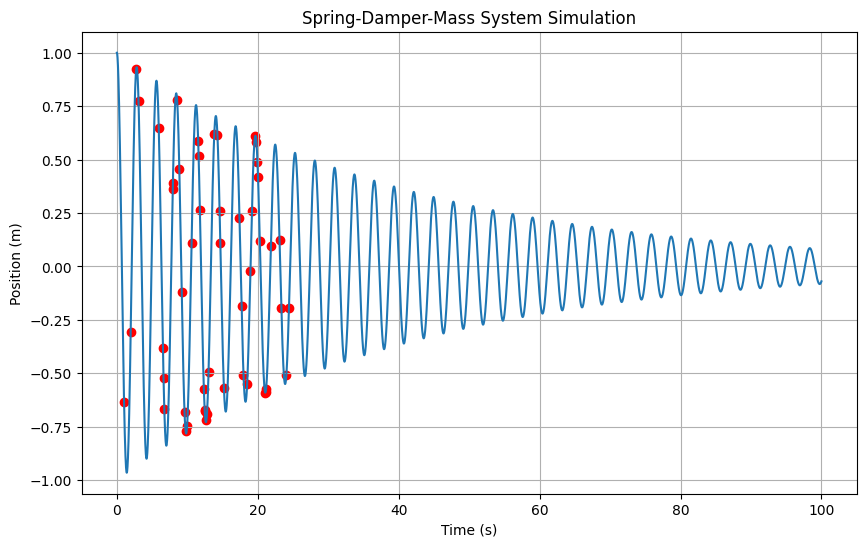

In [ ]:
n = 50  # Number of samples
t_max = 25.0 # Maximum time for sampling

# Find the indices of the time points before t_max
indices_before_t_max = np.where(time < t_max)[0]

# Randomly sample n indices from those before t_max
sampled_indices = np.random.choice(indices_before_t_max, size=n, replace=False)

# Extract the sampled times and positions
t_samples = time[sampled_indices]
x_samples = position[sampled_indices]

print("Sampled times:", t_samples)
print("Sampled positions:", x_samples)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time, position)
plt.scatter(t_samples, x_samples, color='red', label='Sampled Points')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Spring-Damper-Mass System Simulation')
plt.grid(True)
plt.show()

In [ ]:
# Create a PINN class with the NN and the loss functions

import torch
import torch.nn as nn

class PINN(nn.Module):
    def __init__(self, input_dim=1, output_dim=1, num_layers=3, hidden_dim=64, learn_params=True, num_fourier_features=32, k=1, c=1):
        super(PINN, self).__init__()
        self.learn_params = learn_params
        self.num_fourier_features = num_fourier_features

        # Learnable system parameters (initialized, these will be learned if learn_params is True)
        self.k = nn.Parameter(torch.tensor([k], dtype=torch.float32), requires_grad=learn_params)
        self.c = nn.Parameter(torch.tensor([c], dtype=torch.float32), requires_grad=learn_params)
        self.m = 1.0  # Mass is considered known in this case

        # Fourier features mapping
        self.fourier_weights = nn.Parameter(torch.randn(input_dim, num_fourier_features), requires_grad=True)

        # Neural network for displacement x(t)
        layers = []
        # Input layer with Fourier features
        if num_fourier_features > 0:
            layers.append(nn.Linear(input_dim * 2 * num_fourier_features, hidden_dim))
        else:
            layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        # Output layer (displacement)
        layers.append(nn.Linear(hidden_dim, output_dim))

        self.net = nn.Sequential(*layers)

    def forward(self, t):
        if self.num_fourier_features > 0:
            # Apply Fourier Features
            t_fourier = t @ self.fourier_weights
            t_fourier = torch.cat([torch.sin(t_fourier), torch.cos(t_fourier)], dim=-1)

            # Predict displacement x(t)
            x = self.net(t_fourier)

        else:
            x = self.net(t)
        return x

    def physics_informed_loss(self, t):
        # Ensure t requires gradients
        t.requires_grad_(True)

        # Get predicted displacement x(t)
        x = self(t)

        # Calculate velocity v(t) = dx/dt
        v = torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]

        # Calculate acceleration a(t) = dv/dt
        a = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v), create_graph=True)[0]

        # Physics-informed loss: m*a + c*v + k*x = 0
        pde_residual = self.m * a + self.c * v + self.k * x
        #pde_residual = pde_residual/(self.m*v**2/2 + self.k*x**2/2)

        # Mean squared error for the PDE residual
        loss_pde = torch.mean(pde_residual**2)

        return loss_pde

    def data_loss(self, t_data, x_data):
        # Predict displacement at data points
        x_pred = self(t_data)

        # Mean squared error for the data points
        loss_data = torch.mean((x_pred - x_data)**2)

        return loss_data

Epoch [100/5000], Total Loss: 0.001814, Data Loss: 0.001814
Epoch [200/5000], Total Loss: 0.000128, Data Loss: 0.000128
Epoch [300/5000], Total Loss: 0.000042, Data Loss: 0.000042
Epoch [400/5000], Total Loss: 0.000013, Data Loss: 0.000013
Epoch [500/5000], Total Loss: 0.000006, Data Loss: 0.000006
Epoch [600/5000], Total Loss: 0.000003, Data Loss: 0.000003
Epoch [700/5000], Total Loss: 0.000001, Data Loss: 0.000001
Epoch [800/5000], Total Loss: 0.000004, Data Loss: 0.000004
Epoch [900/5000], Total Loss: 0.000004, Data Loss: 0.000004
Epoch [1000/5000], Total Loss: 0.000001, Data Loss: 0.000001
Epoch [1100/5000], Total Loss: 0.000001, Data Loss: 0.000001
Epoch [1200/5000], Total Loss: 0.000009, Data Loss: 0.000009
Epoch [1300/5000], Total Loss: 0.000001, Data Loss: 0.000001
Epoch [1400/5000], Total Loss: 0.000001, Data Loss: 0.000001
Epoch [1500/5000], Total Loss: 0.000001, Data Loss: 0.000001
Epoch [1600/5000], Total Loss: 0.000021, Data Loss: 0.000021
Epoch [1700/5000], Total Loss: 0.

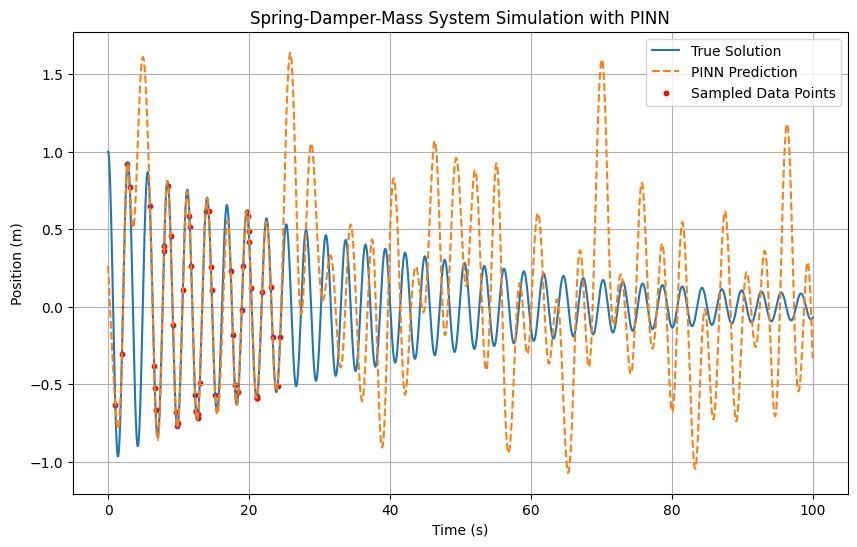

In [ ]:
# Before using PINN, let's just train without physics

# Convert numpy arrays to PyTorch tensors
t_data_tensor = torch.tensor(t_samples, dtype=torch.float32).unsqueeze(-1)
x_data_tensor = torch.tensor(x_samples, dtype=torch.float32).unsqueeze(-1)

# Create the PINN model
nn_model = PINN(learn_params=False)

# Optimizer
optimizer = torch.optim.Adam(nn_model.parameters(), lr=1e-3)

# Training loop
num_epochs = 5000
lambda_pde = 0.1 # Weight for the physics-informed loss

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Calculate data loss
    loss_data = nn_model.data_loss(t_data_tensor, x_data_tensor)

    # Total loss
    total_loss = loss_data

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss.item():.6f}, Data Loss: {loss_data.item():.6f}')

print("Training finished.")

# Evaluate the trained model
t_eval = torch.tensor(time, dtype=torch.float32).unsqueeze(-1)
with torch.no_grad():
    x_pred = nn_model(t_eval).squeeze().numpy()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time, position, label='True Solution')
plt.plot(time, x_pred, label='PINN Prediction', linestyle='--')
plt.scatter(t_samples, x_samples, color='red', label='Sampled Data Points', s=10)
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Spring-Damper-Mass System Simulation with PINN')
plt.legend()
plt.grid(True)
plt.show()

Epoch [100/5000], Total Loss: 0.121714, Data Loss: 0.070464, PDE Loss: 0.512499, Learned k: 1.1205, Learned c: 0.8865
Epoch [200/5000], Total Loss: 0.113495, Data Loss: 0.065729, PDE Loss: 0.477666, Learned k: 1.2287, Learned c: 0.7836
Epoch [300/5000], Total Loss: 0.108706, Data Loss: 0.061312, PDE Loss: 0.473940, Learned k: 1.3351, Learned c: 0.6870
Epoch [400/5000], Total Loss: 0.105057, Data Loss: 0.059200, PDE Loss: 0.458574, Learned k: 1.4442, Learned c: 0.5951
Epoch [500/5000], Total Loss: 0.101627, Data Loss: 0.055633, PDE Loss: 0.459945, Learned k: 1.5574, Learned c: 0.5095
Epoch [600/5000], Total Loss: 0.099552, Data Loss: 0.053006, PDE Loss: 0.465455, Learned k: 1.6734, Learned c: 0.4297
Epoch [700/5000], Total Loss: 0.092794, Data Loss: 0.050227, PDE Loss: 0.425671, Learned k: 1.7922, Learned c: 0.3577
Epoch [800/5000], Total Loss: 0.091661, Data Loss: 0.046423, PDE Loss: 0.452374, Learned k: 1.9145, Learned c: 0.2929
Epoch [900/5000], Total Loss: 0.088435, Data Loss: 0.043

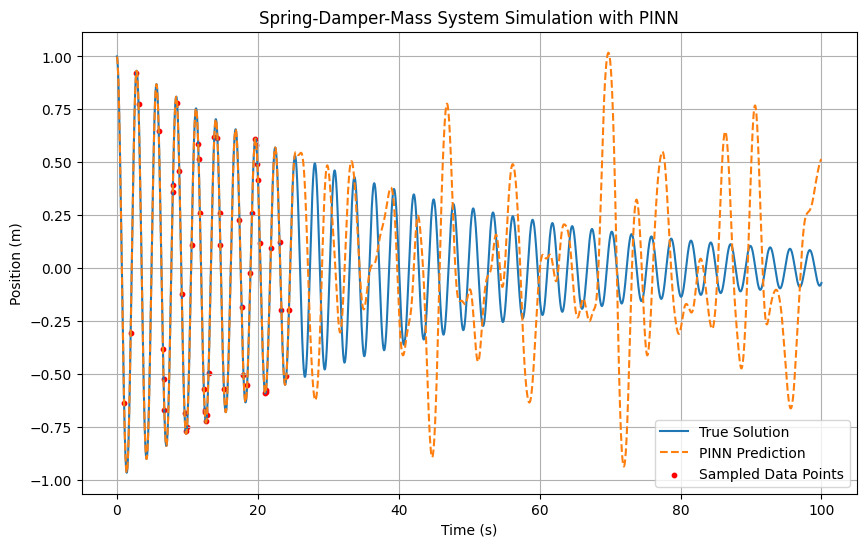

In [ ]:
# First, learn the parameters

# Convert numpy arrays to PyTorch tensors
t_data_tensor = torch.tensor(t_samples, dtype=torch.float32).unsqueeze(-1)
x_data_tensor = torch.tensor(x_samples, dtype=torch.float32).unsqueeze(-1)

# Create the PINN model
pinn_model = PINN(learn_params=True) # Set learn_params to True to learn k and c

# Optimizer
optimizer = torch.optim.Adam(pinn_model.parameters(), lr=1e-3)

# Training loop
num_epochs = 5000
lambda_pde = 0.1 # Weight for the physics-informed loss

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Calculate data loss
    loss_data = pinn_model.data_loss(t_data_tensor, x_data_tensor)

    # Calculate physics-informed loss using sampled times (or time grid)
    t_physics_tensor = torch.rand(1000, 1) * (t_max - t_start) + t_start
    t_physics_tensor.requires_grad_(True)
    loss_pde = pinn_model.physics_informed_loss(t_physics_tensor)

    # Total loss
    total_loss = loss_data + lambda_pde * loss_pde

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss.item():.6f}, Data Loss: {loss_data.item():.6f}, PDE Loss: {loss_pde.item():.6f}, Learned k: {pinn_model.k.item():.4f}, Learned c: {pinn_model.c.item():.4f}')

print("Training finished.")
print(f"Learned k: {pinn_model.k.item()}")
print(f"Learned c: {pinn_model.c.item()}")

# Evaluate the trained model
t_eval = torch.tensor(time, dtype=torch.float32).unsqueeze(-1)
with torch.no_grad():
    x_pred = pinn_model(t_eval).squeeze().numpy()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time, position, label='True Solution')
plt.plot(time, x_pred, label='PINN Prediction', linestyle='--')
plt.scatter(t_samples, x_samples, color='red', label='Sampled Data Points', s=10)
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Spring-Damper-Mass System Simulation with PINN')
plt.legend()
plt.grid(True)
plt.show()

Epoch [100/5000], Total Loss: 0.011208, Data Loss: 0.002397, PDE Loss: 0.008811, Learned k: 5.0010, Learned c: 0.0491
Epoch [200/5000], Total Loss: 0.003160, Data Loss: 0.000304, PDE Loss: 0.002856, Learned k: 5.0010, Learned c: 0.0491
Epoch [300/5000], Total Loss: 0.003487, Data Loss: 0.000196, PDE Loss: 0.003291, Learned k: 5.0010, Learned c: 0.0491
Epoch [400/5000], Total Loss: 0.002046, Data Loss: 0.000068, PDE Loss: 0.001978, Learned k: 5.0010, Learned c: 0.0491
Epoch [500/5000], Total Loss: 0.001716, Data Loss: 0.000055, PDE Loss: 0.001661, Learned k: 5.0010, Learned c: 0.0491
Epoch [600/5000], Total Loss: 0.001316, Data Loss: 0.000043, PDE Loss: 0.001273, Learned k: 5.0010, Learned c: 0.0491
Epoch [700/5000], Total Loss: 0.001188, Data Loss: 0.000050, PDE Loss: 0.001138, Learned k: 5.0010, Learned c: 0.0491
Epoch [800/5000], Total Loss: 0.001970, Data Loss: 0.000098, PDE Loss: 0.001872, Learned k: 5.0010, Learned c: 0.0491
Epoch [900/5000], Total Loss: 0.000903, Data Loss: 0.000

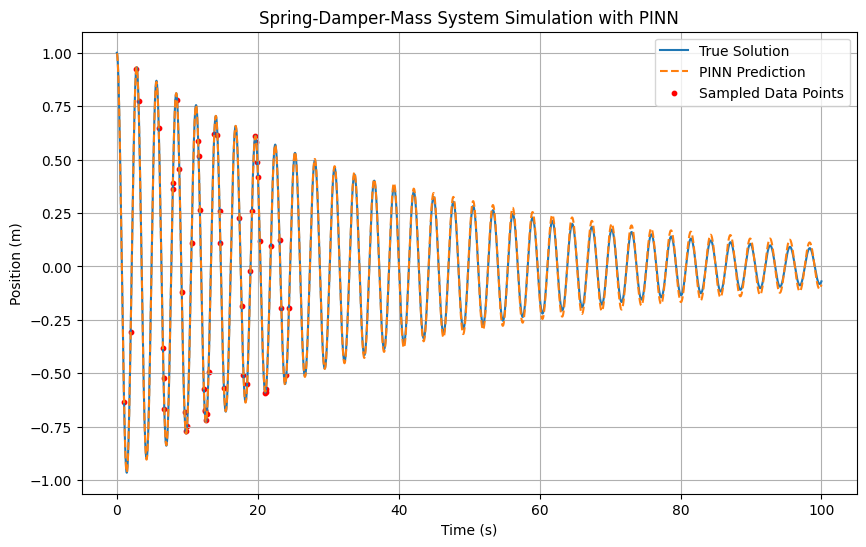

In [ ]:
# Now, extrapolate

# Convert numpy arrays to PyTorch tensors
t_data_tensor = torch.tensor(t_samples, dtype=torch.float32).unsqueeze(-1)
x_data_tensor = torch.tensor(x_samples, dtype=torch.float32).unsqueeze(-1)

# Create the PINN model
pinn_model = PINN(learn_params=False,k=pinn_model.k.item(),c=pinn_model.c.item()) # Set learn_params to True to learn k and c

# Optimizer
optimizer = torch.optim.Adam(pinn_model.parameters(), lr=3e-3)

# Training loop
num_epochs = 5000
lambda_pde = 1 # Weight for the physics-informed loss

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Calculate data loss
    loss_data = pinn_model.data_loss(t_data_tensor, x_data_tensor)

    # Calculate physics-informed loss using sampled times (or time grid)
    t_physics_tensor = torch.rand(1000, 1) * (t_end - t_start) + t_start
    t_physics_tensor.requires_grad_(True)
    loss_pde = pinn_model.physics_informed_loss(t_physics_tensor)

    # Total loss
    total_loss = loss_data + lambda_pde * loss_pde

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss.item():.6f}, Data Loss: {loss_data.item():.6f}, PDE Loss: {loss_pde.item():.6f}, Learned k: {pinn_model.k.item():.4f}, Learned c: {pinn_model.c.item():.4f}')

print("Training finished.")
print(f"Learned k: {pinn_model.k.item()}")
print(f"Learned c: {pinn_model.c.item()}")

# Evaluate the trained model
t_eval = torch.tensor(time, dtype=torch.float32).unsqueeze(-1)
with torch.no_grad():
    x_pred = pinn_model(t_eval).squeeze().numpy()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time, position, label='True Solution')
plt.plot(time, x_pred, label='PINN Prediction', linestyle='--')
plt.scatter(t_samples, x_samples, color='red', label='Sampled Data Points', s=10)
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Spring-Damper-Mass System Simulation with PINN')
plt.legend()
plt.grid(True)
plt.show()

Epoch [100/10000], Total Loss: 0.048639, Data Loss: 0.016897, PDE Loss: 0.317423, Learned k: 1.2770, Learned c: 0.7205
Epoch [200/10000], Total Loss: 0.042778, Data Loss: 0.014429, PDE Loss: 0.283494, Learned k: 1.5714, Learned c: 0.4841
Epoch [300/10000], Total Loss: 0.036289, Data Loss: 0.011213, PDE Loss: 0.250769, Learned k: 1.8799, Learned c: 0.2956
Epoch [400/10000], Total Loss: 0.033145, Data Loss: 0.007497, PDE Loss: 0.256478, Learned k: 2.2117, Learned c: 0.1637
Epoch [500/10000], Total Loss: 0.026042, Data Loss: 0.006088, PDE Loss: 0.199540, Learned k: 2.5657, Learned c: 0.0871
Epoch [600/10000], Total Loss: 0.019546, Data Loss: 0.004582, PDE Loss: 0.149644, Learned k: 2.9212, Learned c: 0.0564
Epoch [700/10000], Total Loss: 0.016356, Data Loss: 0.002751, PDE Loss: 0.136053, Learned k: 3.2567, Learned c: 0.0347
Epoch [800/10000], Total Loss: 0.014933, Data Loss: 0.001205, PDE Loss: 0.137278, Learned k: 3.5662, Learned c: 0.0443
Epoch [900/10000], Total Loss: 0.008002, Data Lo

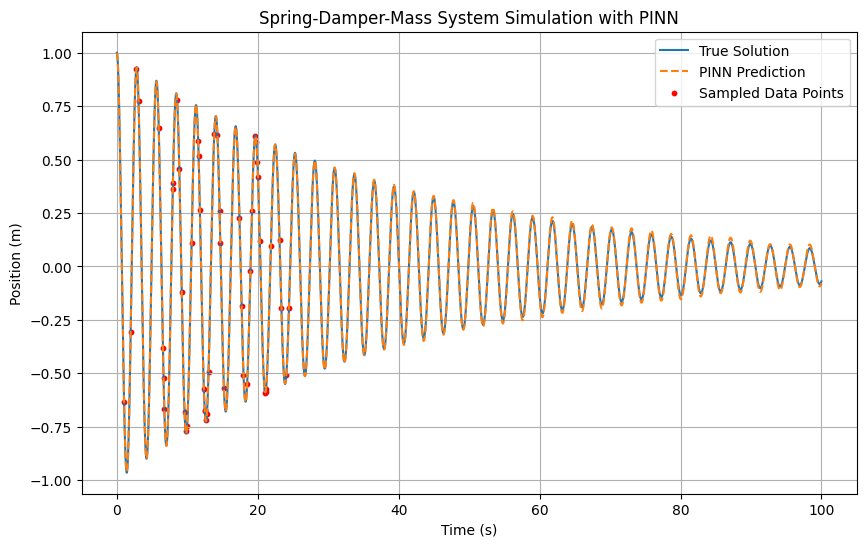

In [ ]:
# Alternativelly, learn parameters and extrapolate at once

# Convert numpy arrays to PyTorch tensors
t_data_tensor = torch.tensor(t_samples, dtype=torch.float32).unsqueeze(-1)
x_data_tensor = torch.tensor(x_samples, dtype=torch.float32).unsqueeze(-1)

# Create the PINN model
pinn_model = PINN(learn_params=True) # Set learn_params to True to learn k and c

# Optimizer
optimizer = torch.optim.Adam(pinn_model.parameters(), lr=3e-3)

# Training loop
num_epochs = 10000
lambda_pde = 0.1 # Weight for the physics-informed loss

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Calculate data loss
    loss_data = pinn_model.data_loss(t_data_tensor, x_data_tensor)

    # Calculate physics-informed loss using sampled times (or time grid)
    t_physics_tensor = torch.rand(1000, 1) * (t_end - t_start) + t_start
    t_physics_tensor.requires_grad_(True)
    loss_pde = pinn_model.physics_informed_loss(t_physics_tensor)

    # Total loss
    total_loss = loss_data + lambda_pde * loss_pde

    # Backpropagation
    total_loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss.item():.6f}, Data Loss: {loss_data.item():.6f}, PDE Loss: {loss_pde.item():.6f}, Learned k: {pinn_model.k.item():.4f}, Learned c: {pinn_model.c.item():.4f}')

print("Training finished.")
print(f"Learned k: {pinn_model.k.item()}")
print(f"Learned c: {pinn_model.c.item()}")

# Evaluate the trained model
t_eval = torch.tensor(time, dtype=torch.float32).unsqueeze(-1)
with torch.no_grad():
    x_pred = pinn_model(t_eval).squeeze().numpy()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(time, position, label='True Solution')
plt.plot(time, x_pred, label='PINN Prediction', linestyle='--')
plt.scatter(t_samples, x_samples, color='red', label='Sampled Data Points', s=10)
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Spring-Damper-Mass System Simulation with PINN')
plt.legend()
plt.grid(True)
plt.show()